In [2]:
# imports

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [3]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
# More imports after HF login

from loaders import ItemLoader
from items import Item

In [6]:
%matplotlib inline

## The ItemLoader code

Look in loaders.py - there's some useful code to make life easier for us

In [10]:
# Load in the same dataset as last time

items = ItemLoader("Appliances").load()

Loading dataset Appliances


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:42<00:00,  2.26it/s]


Completed Appliances with 28,625 datapoints in 0.8 mins


In [11]:
# Look for a familiar item..
print(items[1].prompt)

How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort to guarantee you are totally

Price is $17.00


## Now to SCALE UP

Let's look at all datasets of all the items that you might find in a large home retail store - electrical, electronic, office and related, but not clothes / beauty / books.

In [12]:
dataset_names = [
    "Electronics",
    "Cell_Phones_and_Accessories",
    "Appliances",
]

In [13]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

# Now, time for a coffee break!!
# By the way, I put the biggest datasets first.. it gets faster.

Loading dataset Electronics


meta_Electronics.jsonl:   0%|          | 0.00/5.25G [00:00<?, ?B/s]

C:\Users\santh\anaconda3\envs\llms\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\santh\.cache\huggingface\hub\datasets--McAuley-Lab--Amazon-Reviews-2023. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Generating full split:   0%|          | 0/1610012 [00:00<?, ? examples/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1611/1611 [12:04<00:00,  2.22it/s]


Completed Electronics with 443,473 datapoints in 96.3 mins
Loading dataset Cell_Phones_and_Accessories


meta_Cell_Phones_and_Accessories.jsonl:   0%|          | 0.00/4.02G [00:00<?, ?B/s]

Generating full split:   0%|          | 0/1288490 [00:00<?, ? examples/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1289/1289 [15:53<00:00,  1.35it/s]


Completed Cell_Phones_and_Accessories with 238,869 datapoints in 78.9 mins
Loading dataset Appliances


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [01:39<00:00,  1.05s/it]


Completed Appliances with 28,625 datapoints in 1.8 mins


In [14]:
print(f"A grand total of {len(items):,} items")

A grand total of 710,967 items


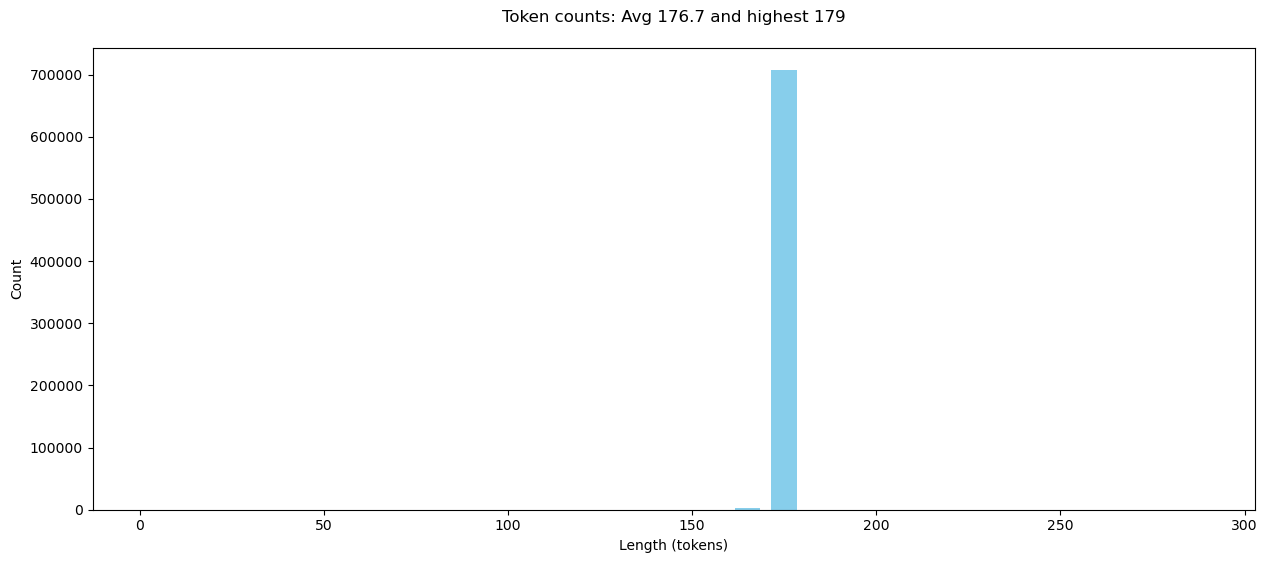

In [15]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

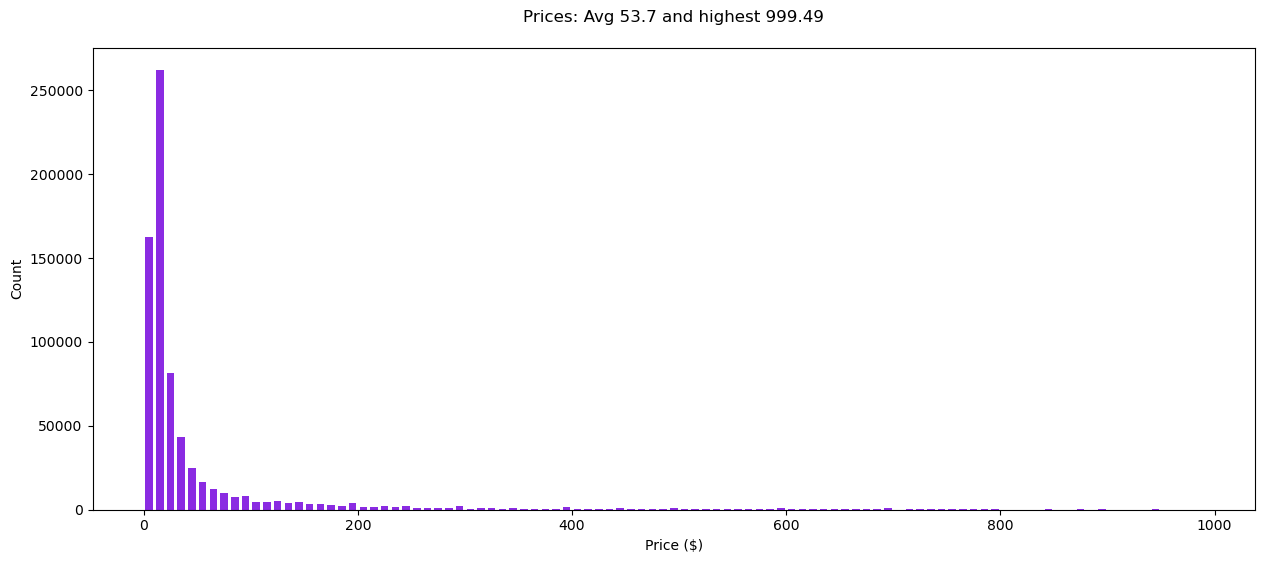

In [16]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

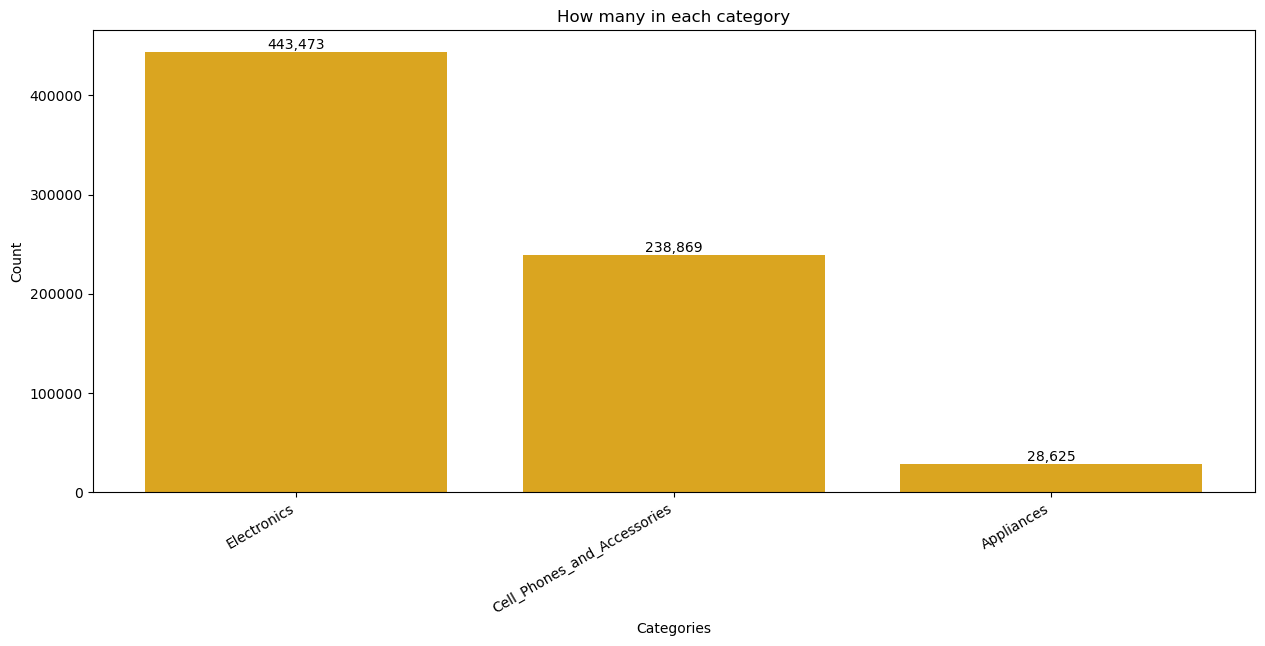

In [17]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

# Objective

Craft a dataset which is more balanced in terms of prices. Less heavily scewed to cheap items, with an average that's higher than $60. Try to balance out the categories - fewer Automotive items.

In [18]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [23]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set random seed for reproducibility

np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 174,405 items in the sample


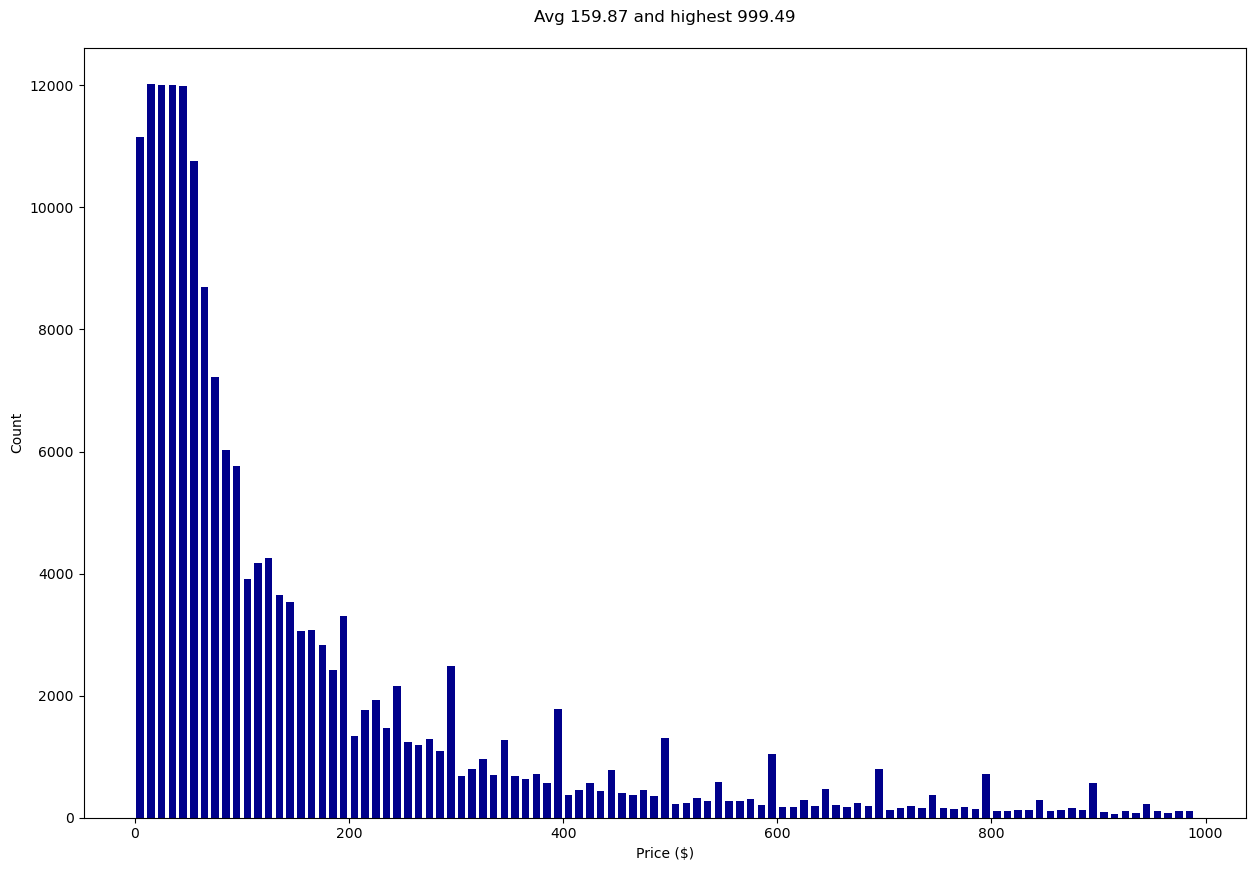

In [24]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

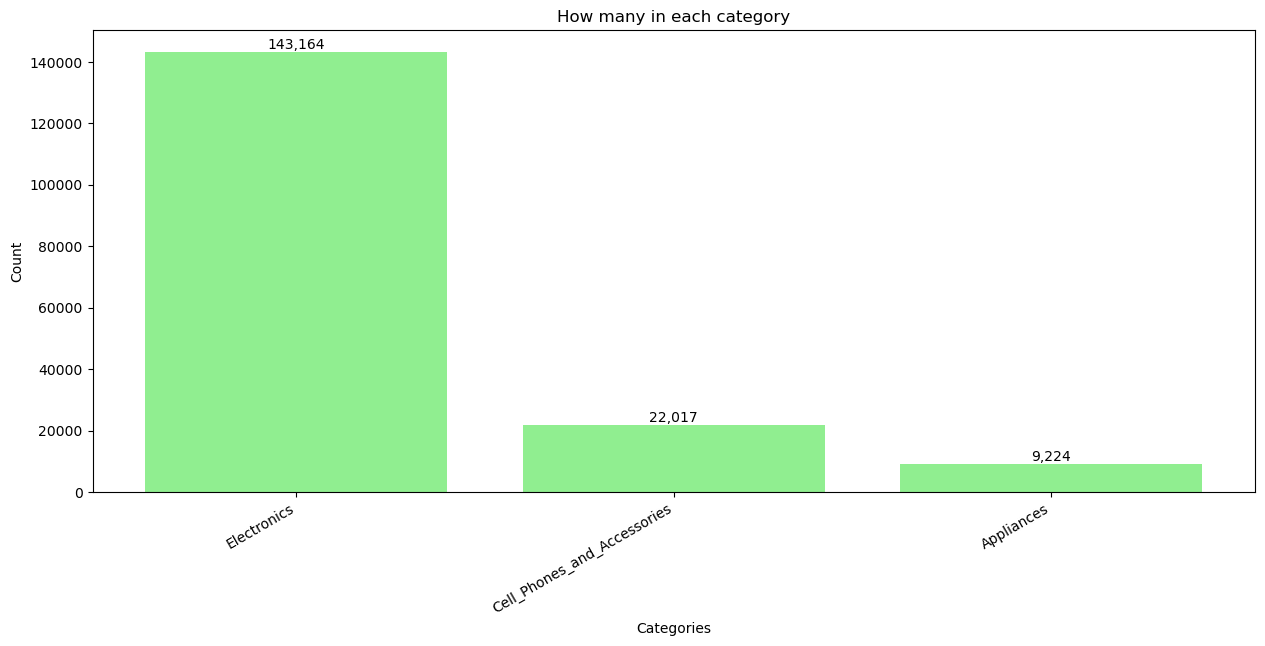

In [25]:
# OK, we did well in terms of raising the average price and having a smooth-ish population of prices
# Let's see the categories

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

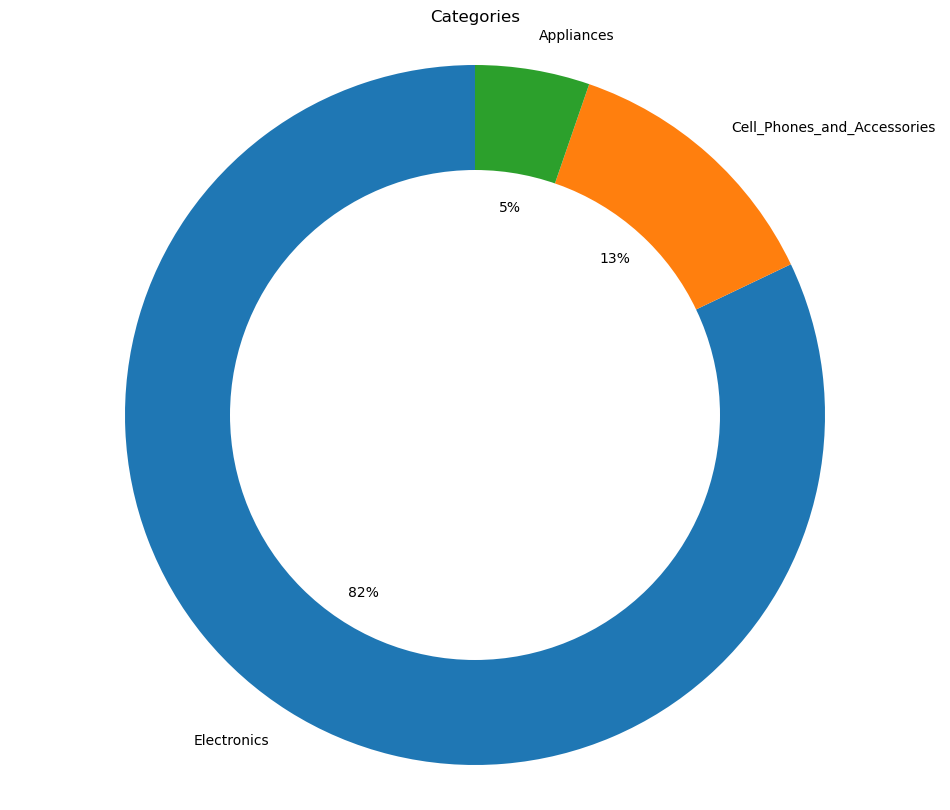

In [26]:
# Automotive still in the lead, but improved somewhat
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

# Dataset Curated!

Let's do some final checks

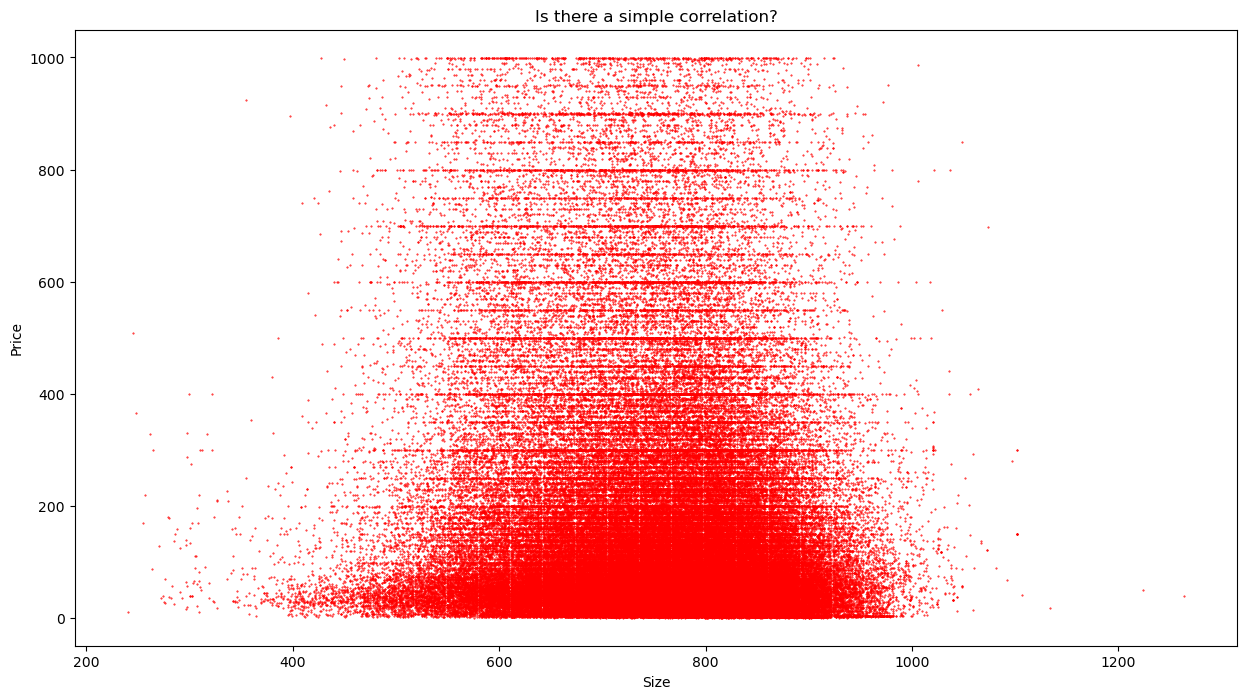

In [27]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [29]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [33]:
report(sample[174404]) #Checking for the last and first datapoint to see how it looks 

How much does this cost to the nearest dollar?

Commercial Top Chest Freezer - Kitma 15.9 Cu. Ft Deep Ice Cream Freezer with 2 Storage Baskets, Adjustable Thermostat, Lock,Rollers, White
Quality Warranty Our products are all certified in the United States,we provide 24 hours / 7 days Customer Service and 1 years prompt responses onsite services including parts & labour. When your product has broken, we will perform “maintenance staff on-site service” within 48 hours. Make sure every item we sold in integral and have good working condition 15.9 Cu. Ft Capacity Size 15.9 Cu.Ft chest freezer has a 1-year warranty, and it is perfect for your large storage needs Temperatu Control This chest freezer foamed in place polyurethane insulation and environmentally friendly refriger

Price is $999.00
[57340, 11919, 30477, 271, 7117, 374, 400, 5500, 13, 410]
[' environmentally', ' friendly', ' refriger', '\n\n', 'Price', ' is', ' $', '999', '.', '00']



# Time to break down our data into a training, test and validation dataset.

It's typical to use 5%-10% of your data for testing purposes, but actually we have far more than we need at this point. We'll take 400,000 points for training, and we'll reserve 2,000 for testing, although we won't use all of them.


In [34]:
random.seed(42)
random.shuffle(sample)
train = sample[:172_404]
test = sample[172_404:174_404]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 172,404 items and test set of 2,000 items


In [35]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

A-Tech 4GB STICK For Acer Aspire Series 5750Z 5940G 5943G (2 Slots) 5943G (4 Slots) 595. SO-DIMM DDR3 NON-ECC RAM Memory
4GB STICK SO-DIMM DDR3 NON-ECC RAM Memory Genuine A-Tech Memory Lifetime Warranty Designed For Acer Aspire Series. (See Compatibility List Below) RAM 4 GB Brand A-Tech, model number Weight 0.6 ounces, Dimensions 4.2 x 2.3 x 0.4 inches, Dimensions LxWxH 4.2 x 2.3 x 0.4 inches, Computer Memory Type DDR3 SDRAM, Manufacturer A-Tech, Country of Origin

Price is $36.00


In [36]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Fast Intel (up to Latitude E5440 Laptop PC 14'' - 'New' 120GB SSD- 8GB DDR3 RAM - Windows 10 Professional 64-Bit - WiFi - DVD±RW
Nice Computer! Standing screen display size 14 Inches, Screen Resolution 1366 x 768 pixels, Max Screen Resolution 1366 x 768 pixels, RAM 8 GB DDR3, Hard Drive 120 GB SSD, Chipset Brand Intel, Card Description Integrated, Wireless Type USB 2.0 Ports 2, Brand Dell, Series Dell Latitude, model number Operating System Windows 10 Pro, Weight 4.41 pounds, Processor Brand Intel, Processors 2, Computer Memory Type DDR3 SDRAM, Power Source Battery Powered, Rank Computers & Accessories

Price is $


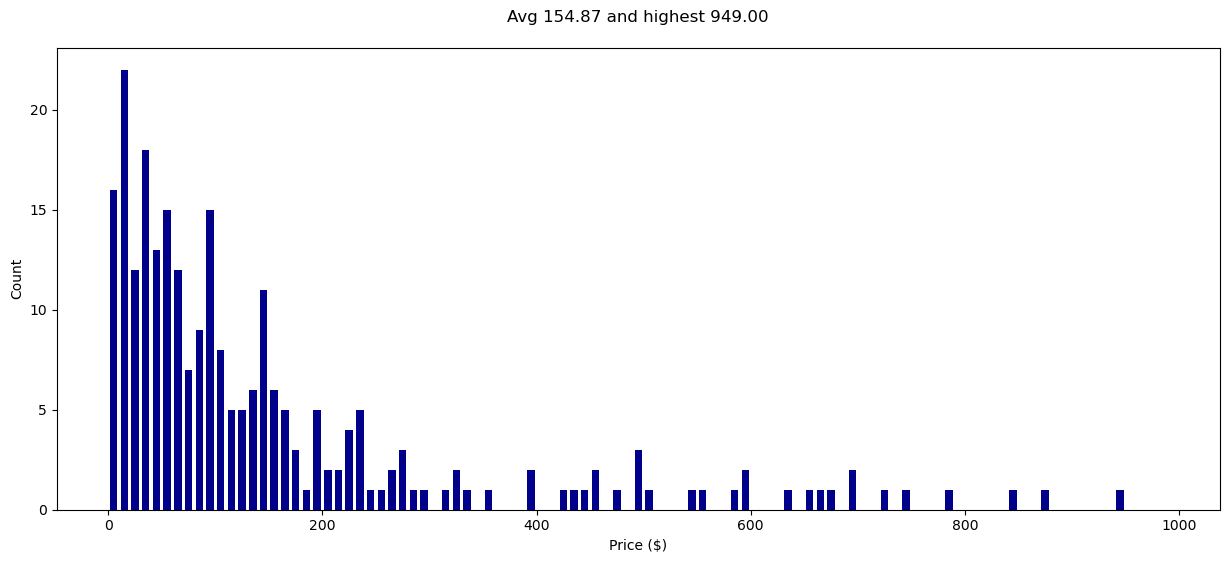

In [37]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

# Finally - upload your brand new dataset

Convert to prompts and upload to HuggingFace hub

In [39]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [40]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [ ]:
#Push to the hub

HF_USER = "santy171710"
DATASET_NAME = f"{HF_USER}/price-estimator-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/173 [00:00<?, ?ba/s]

Uploading...:   0%|          | 0.00/76.8M [00:00<?, ?B/s]

In [ ]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)